## Introduction to Data Science

### Pytorch Primer

Inspired by [this](https://medium.com/dair-ai/pytorch-1-2-introduction-guide-f6fa9bb7597c) post.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from IPython.display import display, Image
from IPython.core.interactiveshell import InteractiveShell

%matplotlib inline

In [2]:
print(torch.__version__)

1.3.0


### Loading data

- BATCH_SIZE is a parameter that denotes the batch size we will use for our model
- transform holds code for whatever transformations you will apply to your data. I will show you an example below to demonstrate exactly what it does to shed more light into its use
- trainset and testset contain the actual dataset object. Notice I use train=True to specify that this corresponds to the training dataset, and I use train=False to specify that this is the remainder of the dataset which we call the test set. From the block I printed above you can see that the split of the data was 85% (60000) / 15% (10000), corresponding to the portions of samples for the training set and testing set, respectively
- trainloader is what holds the data loader object which takes care of shuffling the data and constructing the batches

In [3]:
## parameter denoting the batch size
BATCH_SIZE = 32

## transformations
transform = transforms.Compose([transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [4]:
print(trainset)
print(testset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


Now let’s take a closer look at that transforms.Compose(...) function and see what it does. We will use a randomly generated image to demonstrate its use. Let's generate an image:

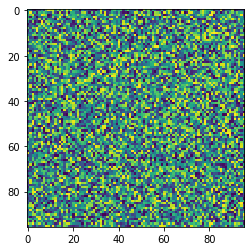

In [5]:
image = transforms.ToPILImage(mode='L')(torch.randn(1, 96, 96))
plt.imshow(image)